In [1]:
import pickle

In [ ]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

# =============================================
# Configuration
# =============================================
parent_dir = "/home/infres/zzhu-24/PRIM/VLM2Vec/experiments/public/exps/vlm2vec_retrieval/VLM2Vec-V2.0-Qwen2VL-2B"

# Metrics to extract
metrics_to_read = [
    "hit@1", "ndcg_linear@1", "ndcg_exponential@1",
    "hit@5", "ndcg_linear@5", "ndcg_exponential@5",
    "hit@10", "ndcg_linear@10", "ndcg_exponential@10"
]

# =============================================
# Step 1: Collect data
# =============================================
results = []

# Helper: extract layer index from folder name
def get_layer_index(name):
    try:
        return int(name.split("_")[1])
    except Exception:
        return 1e9  # put non-layer folders at the end

# Iterate over all subdirectories, sorted numerically by layer index
for child_name in sorted(os.listdir(parent_dir), key=get_layer_index):
    if not child_name.startswith("layer_"):
        continue
    child_path = os.path.join(parent_dir, child_name)
    score_path = os.path.join(child_path, "retrieval", "MSCOCO_i2t_score.json")

    if not os.path.exists(score_path):
        print(f"⚠️  Skipping: {score_path} not found.")
        continue

    with open(score_path, "r") as f:
        data = json.load(f)

    # Extract metrics if they exist
    record = {"child_dir": child_name, "layer_idx": get_layer_index(child_name)}
    for key in metrics_to_read:
        record[key] = data.get(key, None)

    results.append(record)

# =============================================
# Step 2: Convert to DataFrame and sort
# =============================================
if not results:
    raise RuntimeError("No valid score files found.")

df = pd.DataFrame(results).sort_values(by="layer_idx").reset_index(drop=True)
print("✅ Loaded metrics (sorted by layer index):")
print(df)

# =============================================
# Step 3: Draw graphics
# =============================================

# Create a figure for each metric
for metric in metrics_to_read:
    plt.figure(figsize=(8, 4))
    plt.plot(df["layer_idx"], df[metric], marker="o")
    plt.title(f"{metric} (MSCOCO i2t)")
    plt.xlabel("Layer Index")
    plt.ylabel(metric)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()


✅ Loaded metrics for all models:
                      model  layer_idx  hit@1  ndcg_linear@1  \
0  gme-Qwen2-VL-2B-Instruct          1    0.0            0.0   
1  gme-Qwen2-VL-2B-Instruct          2    0.0            0.0   
2  gme-Qwen2-VL-2B-Instruct          3    0.0            0.0   
3  gme-Qwen2-VL-2B-Instruct          4    0.0            0.0   
4  gme-Qwen2-VL-2B-Instruct          5    0.0            0.0   

   ndcg_exponential@1  hit@5  ndcg_linear@5  ndcg_exponential@5  
0                 0.0  0.005       0.002361            0.002361  
1                 0.0  0.003       0.001649            0.001649  
2                 0.0  0.000       0.000000            0.000000  
3                 0.0  0.001       0.000387            0.000387  
4                 0.0  0.005       0.002135            0.002135  


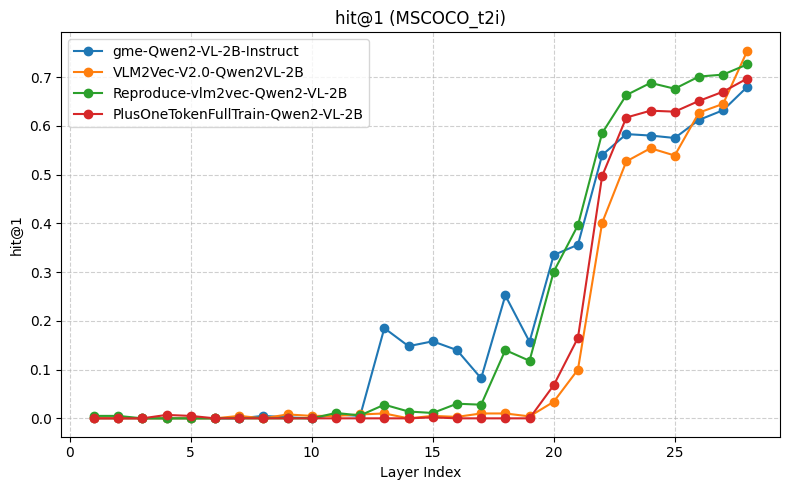

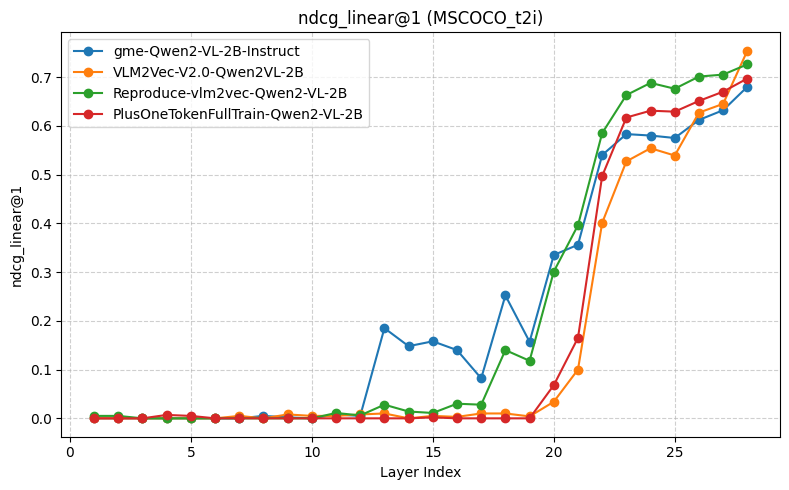

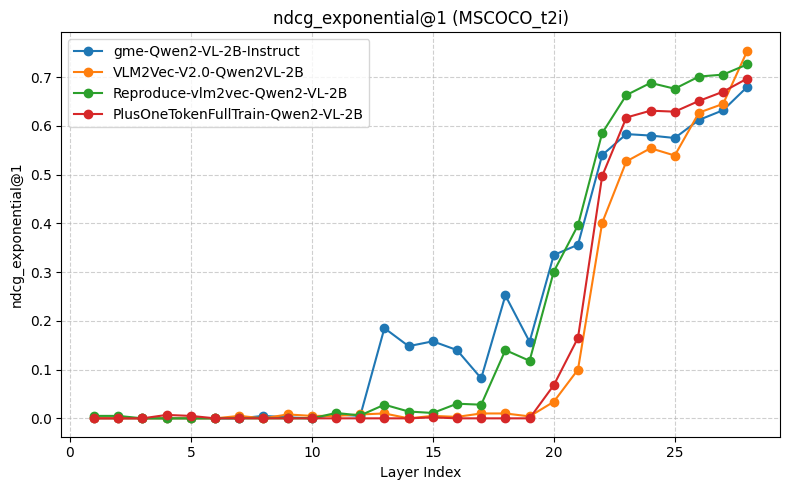

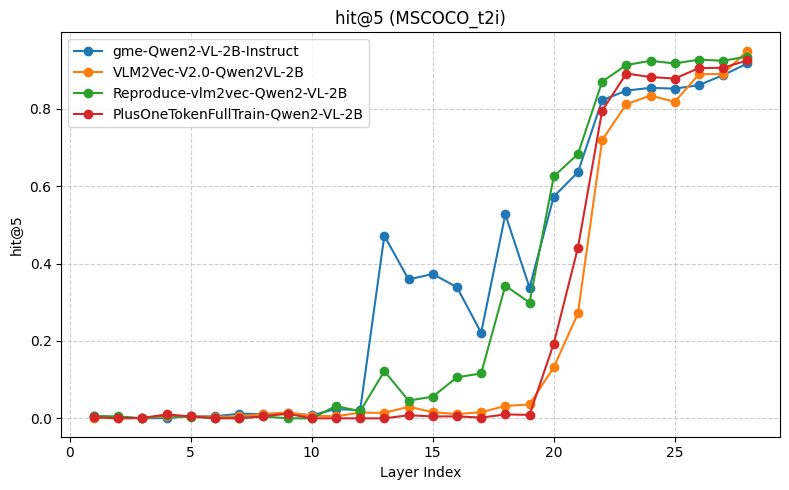

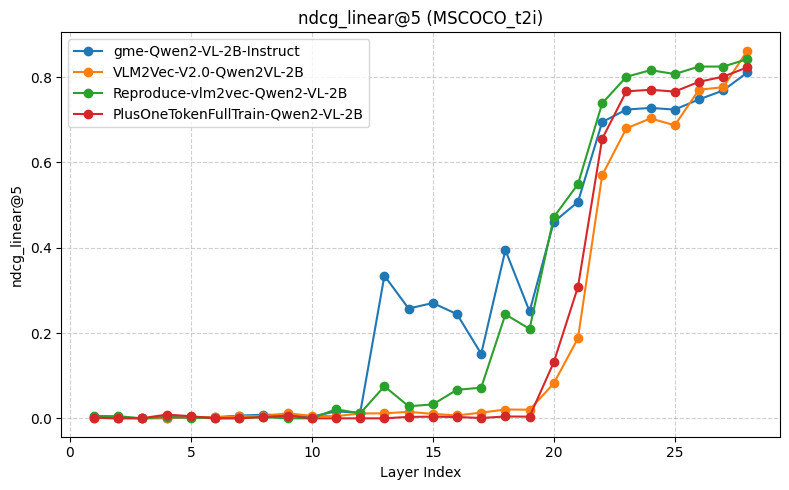

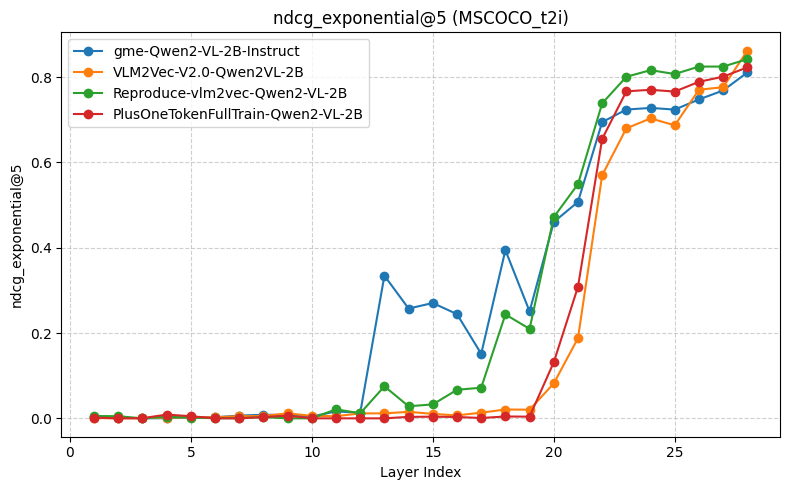

In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

# =============================================
# Configuration
# =============================================

# List of model directories
model_dirs = {
    # "Qwen2-VL-7B": "/home/infres/zzhu-24/PRIM/VLM2Vec/experiments/public/exps/vlm2vec_retrieval/qwen-Qwen2-VL-7B-Instruct",
    # "InternVL-2-8B": "/home/infres/zzhu-24/PRIM/VLM2Vec/experiments/public/exps/vlm2vec_retrieval/internvl2-8b",
    # "MiniCPM-V": "/home/infres/zzhu-24/PRIM/VLM2Vec/experiments/public/exps/vlm2vec_retrieval/minicpm-v",
    "gme-Qwen2-VL-2B-Instruct": "/home/infres/zzhu-24/PRIM/VLM2Vec/experiments/public/exps/vlm2vec_retrieval/gme-Qwen2-VL-2B-Instruct",
    "VLM2Vec-V2.0-Qwen2VL-2B": "/home/infres/zzhu-24/PRIM/VLM2Vec/experiments/public/exps/vlm2vec_retrieval/VLM2Vec-V2.0-Qwen2VL-2B",
    "Reproduce-vlm2vec-Qwen2-VL-2B": "/home/infres/zzhu-24/PRIM/VLM2Vec/experiments/public/exps/eval_after_train/original/qwen-Qwen2-VL-2B-Instruct",
    "PlusOneTokenFullTrain-Qwen2-VL-2B": "/home/infres/zzhu-24/PRIM/VLM2Vec/experiments/public/exps/eval_after_train/05NovA200-Qwen/qwen-Qwen2-VL-2B-Instruct/checkpoint-6000",
    # "TailTokenTrainOnly-Qwen2-VL-2B": "/home/infres/zzhu-24/PRIM/VLM2Vec/experiments/public/exps/eval_after_train/05Nov_tail_only-Qwen/qwen-Qwen2-VL-2B-Instruct/checkpoint-6000",
    # "TailTokenGradOnly-Qwen2-VL-2B": "/home/infres/zzhu-24/PRIM/VLM2Vec/experiments/public/exps/eval_after_train/05Nov_tail_grad_only-Qwen/qwen-Qwen2-VL-2B-Instruct/checkpoint-6000"
    }

# Metrics to extract
metrics_to_read = [
    "hit@1", "ndcg_linear@1", "ndcg_exponential@1",
    "hit@5", "ndcg_linear@5", "ndcg_exponential@5",
]

# Target dataset
# task_name = "FashionIQ"
# task_name = "MSCOCO_i2t"
task_name = "MSCOCO_t2i"

# =============================================
# Helper functions
# =============================================

def get_layer_index(name):
    """Extract numeric layer index from folder name like 'layer_12'."""
    try:
        return int(name.split("_")[1])
    except Exception:
        return 1e9  # non-layer folders sorted to end

def collect_model_data(model_name, model_dir):
    """Collect retrieval metrics for a given model."""
    results = []

    for child_name in sorted(os.listdir(model_dir), key=get_layer_index):
        if not child_name.startswith("layer_"):
            continue
        if child_name.endswith("layer_0"):
            continue

        child_path = os.path.join(model_dir, child_name)
        score_path = os.path.join(child_path, "retrieval", f"{task_name}_score.json")

        if not os.path.exists(score_path):
            print(f"⚠️  Skipping: {score_path} not found.")
            continue

        with open(score_path, "r") as f:
            data = json.load(f)

        record = {
            "model": model_name,
            "layer_idx": get_layer_index(child_name)
        }
        for key in metrics_to_read:
            record[key] = data.get(key, None)
        results.append(record)

    if not results:
        print(f"⚠️  No valid results found for model {model_name}.")
        return None

    return pd.DataFrame(results).sort_values("layer_idx")

# =============================================
# Step 1: Collect data for all models
# =============================================

all_data = []
for model_name, model_dir in model_dirs.items():
    df_model = collect_model_data(model_name, model_dir)
    if df_model is not None:
        all_data.append(df_model)

if not all_data:
    raise RuntimeError("No valid score files found for any model.")

df_all = pd.concat(all_data, ignore_index=True)
print("✅ Loaded metrics for all models:")
print(df_all.head())

# =============================================
# Step 2: Plot all models on the same figure for each metric
# =============================================

for metric in metrics_to_read:
    plt.figure(figsize=(8, 5))
    for model_name in model_dirs.keys():
        df_model = df_all[df_all["model"] == model_name]
        plt.plot(df_model["layer_idx"], df_model[metric],
                 marker="o", label=model_name)

    plt.title(f"{metric} ({task_name})")
    plt.xlabel("Layer Index")
    plt.ylabel(metric)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()
